In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from tcn import TCN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('./data/encoded_data.csv')

# Separating the target variable and excluding it from the input features
input_features = data.drop(['Activity', 'Timestamp'], axis=1)  # Adjust this if the target is in another position
target = data['Activity']

# Calculate the index for a 75-25 split
split_index = int(len(data) * 0.75)

# Split the data into training and testing sets
X_train, X_test = input_features.iloc[:split_index, :], input_features.iloc[split_index:, :]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

# Preparing the data (reshape to fit the TCN input requirements)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31364, 22), (31364,), (10455, 22), (10455,))

In [3]:
X_train.head()

,Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s),Heart Rate (bpm),phone_pos,environment,tired,...,temporal_mean_acceleration y,temporal_std_acceleration y,temporal_mean_acceleration z,temporal_std_acceleration z,temporal_mean_gyroscope x,temporal_std_gyroscope x,temporal_mean_gyroscope y,temporal_std_gyroscope y,temporal_mean_gyroscope z,temporal_std_gyroscope z
0,-3.420972,2.675691,8.604419,-0.272708,-0.055938,0.108734,88.0,0,1,0,...,2.675691,0.112364,8.604419,0.657109,-0.272708,0.157198,-0.055938,0.132447,0.108734,0.032396
1,-2.785414,2.516785,9.533711,-0.050396,-0.243247,0.154549,88.0,0,1,0,...,2.596238,0.112364,9.069065,0.657109,-0.161552,0.157198,-0.149592,0.132447,0.131641,0.032396
2,-2.401145,2.601779,9.402748,0.024251,-0.297064,0.217163,88.0,0,1,0,...,2.598085,0.079518,9.180293,0.503002,-0.099618,0.154477,-0.198749,0.126572,0.160149,0.054431
3,-1.852633,2.452620,9.426451,0.075075,-0.044227,0.393336,88.0,0,1,0,...,2.561719,0.097496,9.241832,0.428745,-0.055944,0.153422,-0.160119,0.129033,0.218445,0.124777
4,-1.564371,2.317587,9.644802,-0.019548,-0.074098,0.662544,88.0,0,1,0,...,2.512893,0.138018,9.322426,0.412727,-0.048665,0.133860,-0.142915,0.118183,0.307265,0.226101


In [4]:
num_classes = len(y_train.unique())
def create_tcn_model(nb_filters, kernel_size, dilations, nb_stacks, dropout_rate):
    input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    x = input_layer
    for _ in range(nb_stacks):
        for dilation in dilations:
            x = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation, padding='causal', activation='relu')(x)
            x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [5]:
# Define hyperparameters grid
hyperparams = {
    'nb_filters': [32, 64],
    'kernel_size': [2, 3],
    'dilations': [(1, 2, 4), (2, 4, 8)],
    'nb_stacks': [1],
    'dropout_rate': [0.0, 0.05]
}

# Training and selecting the best model based on accuracy, recall, and precision
best_accuracy = 0
best_recall = 0
best_precision = 0
best_params = {}

for nb_filters in hyperparams['nb_filters']:
    for kernel_size in hyperparams['kernel_size']:
        for dilations in hyperparams['dilations']:
            for nb_stacks in hyperparams['nb_stacks']:
                for dropout_rate in hyperparams['dropout_rate']:
                    model = create_tcn_model(nb_filters, kernel_size, dilations, nb_stacks, dropout_rate)
                    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    model.fit(X_train_reshaped, y_train, epochs=10, verbose=0)
                    y_pred = model.predict(X_test_reshaped)
                    
                    # Convert predicted probabilities to class labels
                    y_pred_class = np.argmax(y_pred, axis=1)
                    
                    accuracy = accuracy_score(y_test, y_pred_class)
                    
                    print(f'Accuracy: {accuracy},  for params nb_filters={nb_filters}, kernel_size={kernel_size}, dilations={dilations}, nb_stacks={nb_stacks}, dropout_rate={dropout_rate}')
                    
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'nb_filters': nb_filters, 'kernel_size': kernel_size, 'dilations': dilations, 'nb_stacks': nb_stacks, 'dropout_rate': dropout_rate}

print("Best Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=2, dilations=(1, 2, 4), nb_stacks=1, dropout_rate=0.0
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=2, dilations=(1, 2, 4), nb_stacks=1, dropout_rate=0.05
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=2, dilations=(2, 4, 8), nb_stacks=1, dropout_rate=0.0
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=2, dilations=(2, 4, 8), nb_stacks=1, dropout_rate=0.05
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=3, dilations=(1, 2, 4), nb_stacks=1, dropout_rate=0.0
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=3, dilations=(1, 2, 4), nb_stacks=1, dropout_rate=0.05
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 1.0,  for params nb_filters=32, kernel_size=3, dilat

In [6]:
# Test the model on the test set with the best hyperparameters
model = create_tcn_model(nb_filters=32, kernel_size=2, dilations=(1, 2, 4), nb_stacks=1, dropout_rate=0.05)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train, epochs=10, verbose=0)
y_pred = model.predict(X_test_reshaped)
y_pred_class = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='weighted')
precision = precision_score(y_test, y_pred_class, average='weighted')

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}')


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 1.0, Recall: 1.0, Precision: 1.0


c:\Users\liat1\miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


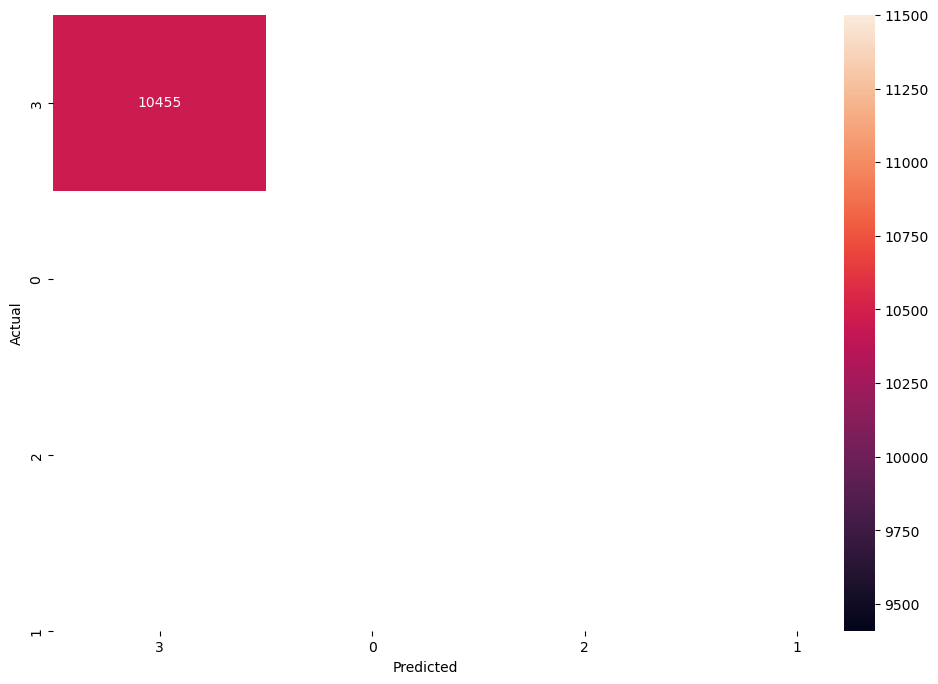

In [7]:
#plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.unique(), yticklabels=target.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
